In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.signal as signal
import sys
import xarray as xr

from scipy.interpolate import interp1d
from scipy.signal import medfilt
from tqdm.notebook import tqdm
from utils.data_reading.sound_data.station import StationsCatalog

In [2]:
# Choix des variables
selected_stations = ["MAHY11", "MAHY21", "MAHY31", "MAHY41"]
depth_choice = 1300 # Select a depth (m) for the hydrology data (e.g. the SOFAR canal)
frequency = 32 # Select a frequency (Hz) at which you want to know the median amplitude

# Chargement des données
sys.path.append("/home/imonge/PycharmProjects/PythonProject/toolbox/src")
catalog_path = "/media/imonge/CORSAIR"  # Path of the hard drive containing MAHY data

In [9]:
# Téléchargement des psd
stations = StationsCatalog(catalog_path)

start_station_name = "MAHY43"
stations_filtered = [s for s in stations if s.name >= start_station_name]

for station in stations_filtered:
    # stations parameters
    if "depth" in station.other_kwargs:
        depth_choice = station.other_kwargs["depth"]  # récupère la colonne depth des csv
    else:
        depth_choice = 1300
    date_start = station.date_start
    date_end = station.date_end

    # acoustic data
    manager = station.get_manager()
    step = datetime.timedelta(seconds=3600)
    n_steps = int((date_end-date_start)/step)
    psds = []
    for i in tqdm(range(n_steps), file=sys.stdout):
        segment_start = date_start + i * step
        segment_end = date_start + (i+1) * step
        data = manager.get_segment(segment_start, segment_end)
        psd_frequencies, psd = signal.welch(data, fs=240, nperseg=1024)
        psds.append(psd)
    np.save("PSDS_" + station.name + ".npy", psds)

  0%|          | 0/8945 [00:00<?, ?it/s]

AssertionError: end is after the last file

In [53]:
# Téléchargement données courant copernicus
station_number = station.name[-1] # cela permet d'avoir le dernier caractère (e.g. "MAHY23"->"3")
hydro_data = xr.open_dataset(f"/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_copernicus/hydro_{station_number}/h{station_number}_total_time.nc") # f"blabla{variable}" permet d'intégrer une variable à un string facilement
t = pd.to_datetime(hydro_data["time"])

for station in stations:
    # stations parameters
    if "depth" in station.other_kwargs:
        depth_choice = station.other_kwargs["depth"]  # récupère la colonne depth des csv
    else:
        depth_choice = 1300
    date_start = station.date_start
    date_end = station.date_end
      # current
    mask = (t>date_start) & (t<date_end)
    depth_index = np.argmin(abs(hydro_data["depth"].data-depth_choice))
    uo = np.array(hydro_data["uo"][:,depth_index]).flatten()
    vo = np.array(hydro_data["vo"][:,depth_index]).flatten()
    velocity_magnitude = np.sqrt(uo**2+vo**2)[mask]
    np.save("velocity_magnitude_" + station.name + ".npy", velocity_magnitude)

/tmp/ipykernel_128811/1654196448.py:19: DeprecationWarning: The 'fix_imports' flag is deprecated and has no effect. (Deprecated in NumPy 2.1)
  np.save("velocity_magnitude_" + station.name + ".npy", velocity_magnitude, date_start, date_end)


In [3]:
# Prendre les dates du csv
cat_info = pd.read_csv(catalog_path + '/MAHY/MAHY.csv', parse_dates=['date_start', 'date_end'])
cat_info.set_index('station_name', inplace=True)
cat_info["date_start"] = pd.to_datetime(cat_info["date_start"])
cat_info["date_end"] = pd.to_datetime(cat_info["date_end"])
#cat_info.loc["MAHY03"] #-> Pour visualiser les infos d'une station

In [4]:
os.chdir("/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_mahy")

In [5]:
# Sélection des stations
%matplotlib qt

# Liste pour stocker les psds
psds_all = []

# Boucle pour stations sélectionnées
for station in selected_stations:
    psds = np.load(f"PSDS_{station}.npy")
    psds_all.append(psds)

date_start = cat_info["date_start"].loc[selected_stations[0]]
date_end = cat_info["date_end"].loc[selected_stations[-1]]

# Concaténation
final_psd = np.vstack(psds_all)

plt.figure(figsize=(16,8))
plt.imshow(10*np.log10(final_psd.T + 1e-12), aspect="auto", origin="lower", cmap="viridis", extent=(date_start, date_end, 0, 120), vmin=10, vmax=95)
plt.colorbar(label="PSD (dB)")
plt.title("Spectro concaténé")
plt.xlabel("Temps")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

In [6]:
# Spectrogram with current velocity
velocity_all = []

for station in selected_stations:
    velocity_magnitude = np.load(f"/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_copernicus/velocity_magnitude_{station}.npy")
    velocity_all.append(velocity_magnitude)

velocity_all = np.hstack(velocity_all)
dates_all = pd.date_range(start=date_start, periods=len(velocity_all))

fig, ax = plt.subplots(figsize = (16,10))
ax1 = ax.twinx() # Second axis for current speed
sp = ax.imshow(10*np.log10(final_psd.T + 1e-12), aspect="auto", origin="lower", cmap="viridis", extent=(date_start, date_end, 0, 120), vmin=10, vmax=95)

ax1.plot(dates_all, velocity_all,label="Current velocity (m/s)", color="blue")
ax1.set_ylim(0,0.4) #limites ax1
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the frequency

ax.set_xlabel("Time")
ax.set_ylabel("Frequency (Hz)")
ax1.set_ylabel("Current velocity (m/s)")
ax1.legend(loc="upper left")

fig.show()


/tmp/ipykernel_473687/3277485124.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


In [7]:
# Amplitude for a given frequency & current velocity
frequency_resolution = 240/1024
frequency_index = int(frequency/frequency_resolution)
psds = np.array(final_psd)
amplitude = psds[:,frequency_index]

amplitude_filt = medfilt(amplitude, kernel_size=51)

amplitude_steps = amplitude_filt.shape[0]
t_amplitude = pd.date_range(
    start=date_start,
    end=date_end,
    periods=amplitude_steps)

fig, ax = plt.subplots(figsize = (14,8))

ax.plot(t_amplitude, amplitude_filt, color="orange", label="Amplitude (median)")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Amplitude (median)", color="orange")
ax.tick_params(axis='y', labelcolor='orange')
#ax.plot(t_amplitude, amplitude, color="red", label="Amplitude")
ax.set_ylim(0,0.07e10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.grid(False, axis='y') # No grid for the amplitude

ax1 = ax.twinx()
ax1.plot(dates_all, velocity_all, color="blue", label="Current velocity (m/s)")
ax1.set_ylim(0,0.4) #limites ax1
ax1.set_ylabel("Current velocity (m/s)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')

plt.title(f"Amplitude médiane à {frequency} Hz et vitesse du courant")
fig.show()

# Test the correlation between the amplitude and the current velocity for the chosen frequency
amplitude_filt = medfilt(amplitude, kernel_size=51)
f = interp1d(pd.to_numeric(dates_all), velocity_all, bounds_error=False)(pd.to_numeric(t_amplitude))
validmask = (~np.isnan(f)) & (~np.isnan(amplitude_filt) & (amplitude_filt != 0)) # remove nan values and null values
corr = np.corrcoef(f[validmask], amplitude_filt[validmask])
print(corr)

[[ 1.         -0.02981098]
 [-0.02981098  1.        ]]


/tmp/ipykernel_473687/3600416565.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


In [8]:
# Graphique des corrélations entre amplitude médiane et vitesse du courant en fonction de la fréquence
amplitude_corr = []

#Calcul de la corrélation pour chaque fréquence
for i in range(final_psd.shape[1]):
   amplitude = final_psd[:,i]
   amplitude_filt = medfilt(amplitude, kernel_size=51)

   if np.sum(validmask) > 0:
       corr_matrix = np.corrcoef(f[validmask], amplitude_filt[validmask])
       amplitude_corr.append(corr_matrix[0,1])
   else:
       amplitude_corr.append(np.nan)

#Calcul des fréquences associées
fs=240
nperseg=1024
frequencies = np.fft.rfftfreq(nperseg, d=1/fs)

# Plot des corrélations
plt.plot(frequencies, amplitude_corr, color="steelblue", label="Corrélation amplitude / vitesse du courant")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Correlation de Pearson")
plt.title("Corrélation entre amplitude sonore et vitesse du courant en fonction de la fréquence")
plt.legend()
plt.tight_layout()
plt.show()

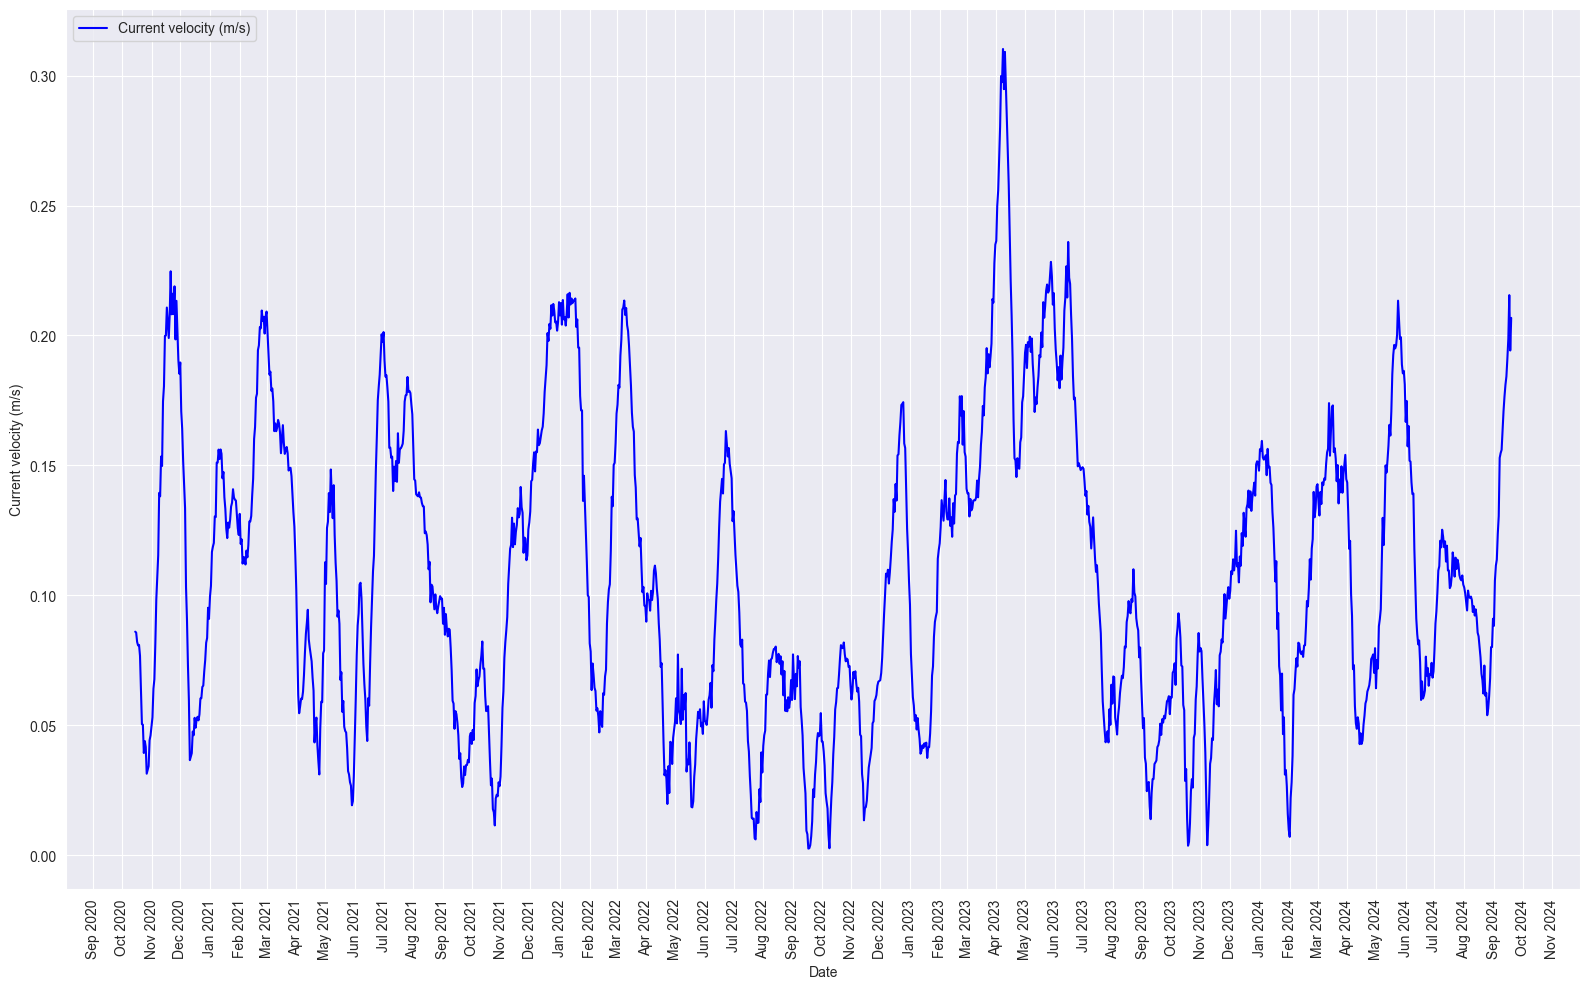

In [52]:
# # Current velocity in time (independent from above)
#
# depth_choice = 1300
#
# hydro_data = xr.open_dataset("/home/imonge/PycharmProjects/PythonProject/toolbox/src/data_copernicus/hydro_4/h4_total_time.nc") # Path of a directory containing the hydrology data (copernicus) for the station selected
# date_start_current = datetime.datetime(2020,10,14,9,17,51)  # exemple : début le 10/10/21 à 5h30 et 25s
# date_end_current = datetime.datetime(2024,9,19,11,30,5)
#
# time_data = hydro_data["time"].values
# time_data = np.array([np.datetime64(t).astype('datetime64[s]').astype(datetime.datetime) for t in time_data])
#
# mask = (time_data >= date_start_current) & (time_data <= date_end_current)
#
#
# depth_index = np.argmin(abs(hydro_data["depth"].data-depth_choice)) # Finds the index in the dataset corresponding to the depth chosen
# uo = np.array(hydro_data["uo"][:,depth_index])[mask].flatten()
# vo = np.array(hydro_data["vo"][:,depth_index])[mask].flatten()
#
# velocity_magnitude = np.sqrt(uo**2+vo**2) # Current velocity
# time_selected = time_data[mask]
#
# plt.figure(figsize=(16,10))
# plt.plot(time_selected, velocity_magnitude,label="Current velocity (m/s)", color="blue")
#
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
#
# plt.xlabel("Date")
# plt.ylabel("Current velocity (m/s)")
# plt.xticks(rotation=90)
# plt.legend(loc="upper left")
# plt.tight_layout()
# plt.grid(True)
# plt.show()